In [1]:
import os
import time

# Self-code imports
import polytopes.baselines as baselines
from polytopes.model.note import Note
from polytopes.model.chord import Chord
import polytopes.polytopical_costs as pc
import polytopes.data_manipulation as dm
import polytopes.pattern_manipulation as pm

#Generic imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

In [2]:
# Database
database_path = "C:\\Users\\amarmore\\Desktop\\Projects\\RWC_annotations\\final_bimbot_al\\"

In [3]:
# Files to load: .seq
auto = []
manual = []
auto_simple = []
manual_simple = []
for file in os.listdir(database_path):
    bag_of_words = file.split(".")
    if bag_of_words[-1] == "seq":
        if bag_of_words[-2] == "auto":
            auto.append(file)
        elif bag_of_words[-2] == "manual":
            manual.append(file)

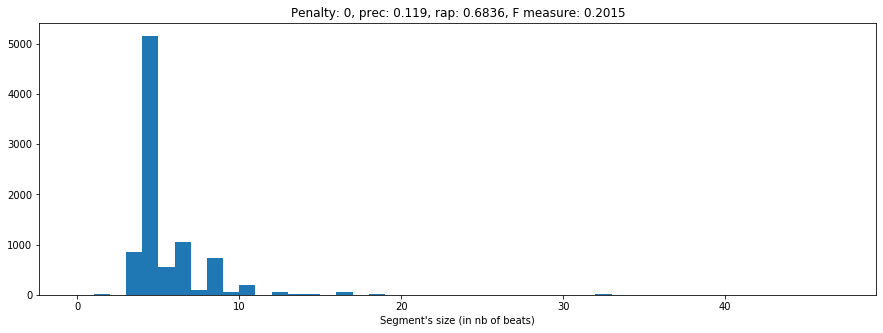

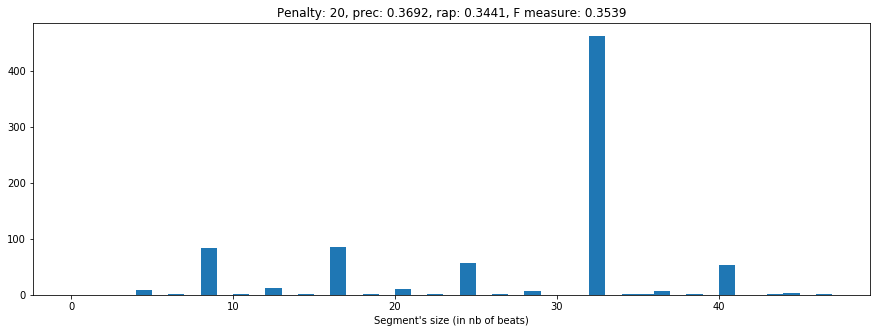

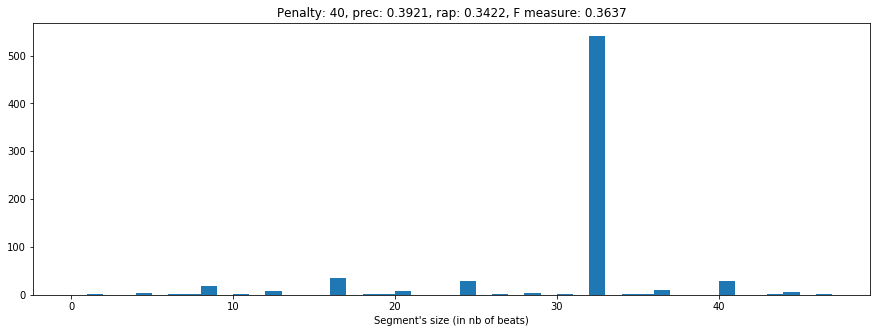

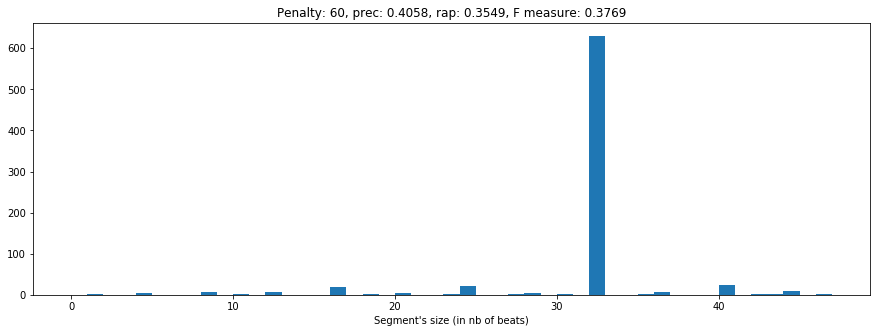

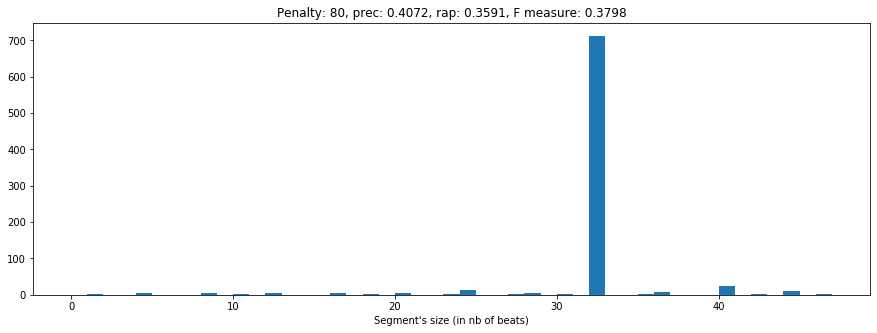

In [4]:
annotations_folder_path = "C:\\Users\\amarmore\\Desktop\\Audio samples\\RWC Pop\\annotations\\MIREX10"
persisted_path = "C:\\Users\\amarmore\\Desktop\\data_persisted"

for i in range(0,100,20):
    all_res = []
    distrib_segments = []
    for song in manual:
        bag_of_chords = dm.flowify_song(database_path + song)
        
        frontiers, _ = baselines.dynamic_minimization_reg_or_seq(bag_of_chords, segment_size_penalty = i, max_size = 48)

        for fst, snd in zip(frontiers[:-1], frontiers[1:]):
            distrib_segments.append(snd - fst)

        """
        # Scores, computed on time
        song_number = song.split(".")[0]
        this_song_ann = dm.get_annotation_name_from_song(song_number, "MIREX10")
        annotation_path = "{}\\{}".format(annotations_folder_path, this_song_ann)
        annotations = dm.get_segmentation_from_txt(annotation_path, "MIREX10")
        references_segments = np.array(annotations)[:, 0:2]
        beats = np.load("{}\\beats\\{}.npy".format(persisted_path, int(song_number)), allow_pickle=True)                

        estimation = []
        for f in frontiers:
            if f < len(beats):
                estimation.append(beats[f])
            else:
                estimation.append(beats[-1])
        estimated_seg = dm.frontiers_to_segments(estimation)

        prec, rec, fmes = dm.compute_score_of_segmentation(references_segments, estimated_seg, window_length = 0.5)"""

        #Scores, computed on the beat annotation
        beat_indexed_segments = dm.frontiers_to_segments(frontiers)
        
        song_number = song.split(".")[0]
        annot_name = "{:03d}.manual.seg".format(int(song_number))
        annotation_file = open(database_path + annot_name,'r')
        annotation = annotation_file.read().replace("\n", "").split(" ")
        annotation = np.array([int(x) - 1 for x in annotation])
        beat_indexed_annotation = np.array(dm.frontiers_to_segments(annotation))
        p, r, f = dm.compute_score_of_segmentation(beat_indexed_annotation, beat_indexed_segments, window_length = 0.5)
        all_res.append([p, r, f])
    
    results = np.array(all_res)
    prec, rap, fmes = round(np.mean(results[:,0]),4), round(np.mean(results[:,1]),4), round(np.mean(results[:,2]),4)
    plt.figure(figsize=(15,5))
    plt.hist(distrib_segments, bins = range(48))
    plt.xlabel("Segment's size (in nb of beats)")
    plt.title("Penalty: {}, prec: {}, rap: {}, F measure: {}".format(i, prec, rap, fmes))
    plt.plot()